In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
# file_dir = os.path.dirname(__file__)
# sys.path.append(file_dir)
sys.path.append('/home/yz685/low_rank_BOPE')
sys.path.append('/home/yz685/low_rank_BOPE/low_rank_BOPE')
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch import Tensor
from tqdm.auto import trange

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.utils.sampling import draw_sobol_samples


from gpytorch import ExactMarginalLogLikelihood
from gpytorch.constraints import GreaterThan
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior
from low_rank_BOPE.bope_class import BopeExperiment
from low_rank_BOPE.test_problems.shapes import AreaUtil, LargestRectangleUtil, GradientAwareAreaUtil, Image
from low_rank_BOPE.src.diagnostics import check_outcome_model_fit, check_util_model_fit

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Y = torch.randn((20,5))
U,S,V = torch.svd(Y)
axes = torch.transpose(V[:, : 3], -2, -1)

In [4]:
axes

tensor([[ 0.1786,  0.2678, -0.5616,  0.6700,  0.3635],
        [-0.1502, -0.9059,  0.0426,  0.2988,  0.2564],
        [ 0.2694,  0.1392,  0.4337, -0.2099,  0.8221]])

In [5]:
torch.pinverse(axes)

tensor([[ 0.1786, -0.1502,  0.2694],
        [ 0.2678, -0.9059,  0.1392],
        [-0.5616,  0.0426,  0.4337],
        [ 0.6700,  0.2988, -0.2099],
        [ 0.3635,  0.2564,  0.8221]])

## Generate test problem

In [5]:
N_PIXELS = 8

problem = Image(num_pixels=N_PIXELS)

# util_func = AreaUtil()
util_func = LargestRectangleUtil(image_shape=(N_PIXELS, N_PIXELS))
# util_func = GradientAwareAreaUtil(penalty_param=0.5, image_shape=(N_PIXELS, N_PIXELS))

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/botorch/test_functions/base.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "bounds", torch.tensor(self._bounds, dtype=torch.float).transpose(-1, -2)


In [6]:
exp = BopeExperiment(
    problem = problem, 
    util_func=util_func, 
    methods=["st","pca"],
    pe_strategies=["Random-f"],
    trial_idx = 31,
    pca_var_threshold = 0.9,
    output_path = "/home/yz685/low_rank_BOPE/experiments/shapes/" + \
        f"{N_PIXELS}by{N_PIXELS}/")

BopeExperiment settings:  {'pca_var_threshold': 0.9, 'initial_experimentation_batch': 16, 'n_check_post_mean': 20, 'every_n_comps': 3, 'verbose': True, 'dtype': torch.float64, 'noise_std': 0.01, 'num_restarts': 20, 'raw_samples': 128, 'batch_limit': 4, 'sampler_num_outcome_samples': 64, 'maxiter': 1000, 'latent_dim': None, 'min_stdv': 100000, 'true_axes': None}
self.methods,  ['pca', 'st']


## Fit outcome model and check fit 

In [8]:
exp.generate_random_experiment_data(n=256, compute_util = False)
exp.fit_outcome_model("pca")

Fitting outcome model using pca


/home/yz685/low_rank_BOPE/low_rank_BOPE/src/transforms.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.axes_learned = torch.tensor(axes_learned, **tkwargs)


torch.Size([1000])
amount of variance explained by 19 axes: 0.9090878462147246


In [9]:
exp.fit_outcome_model("st")

Fitting outcome model using st
torch.Size([1000])


Text(0.5, 0.98, 'Ground truth test images')

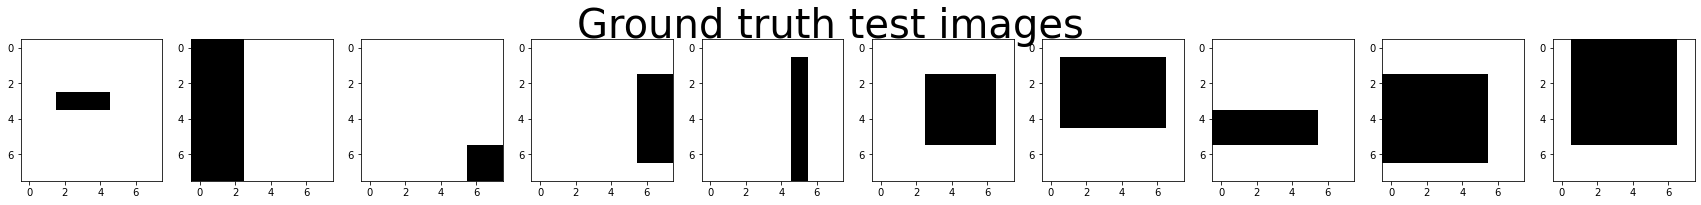

In [39]:
N_TEST=10

test_X = (
            draw_sobol_samples(bounds=exp.problem.bounds, n=1, q=N_TEST, seed=0)
            .squeeze(0)
            .to(torch.double)
            .detach()
        )
img_array = problem(test_X).reshape(N_TEST,N_PIXELS,N_PIXELS).detach().numpy()


fig, ax = plt.subplots(1, N_TEST, figsize = (3*N_TEST, 3))
ax = ax.reshape(-1)

for i in range(10):
    f = ax[i].imshow(img_array[i], cmap=plt.cm.gray_r)

plt.suptitle(f'Ground truth test images', fontsize=40)

In [36]:
"""
Plot images from the posterior
"""


def plot_posterior_images(method, N_TEST = 5, show_rounding = True):

    test_X = (
            draw_sobol_samples(bounds=exp.problem.bounds, n=1, q=N_TEST, seed=0)
            .squeeze(0)
            .to(torch.double)
            .detach()
        )
    test_post_mean = exp.outcome_models_dict[method].posterior(test_X).mean
    print("Area util values: ", util_func(test_post_mean).squeeze(1).detach().numpy())

    img_array = test_post_mean.reshape(N_TEST,N_PIXELS,N_PIXELS).detach().numpy()

    fig, ax = plt.subplots(
        3, N_TEST, 
        figsize = (3*N_TEST, 9)
    )

    for i in range(N_TEST):
        f = ax[0,i].imshow(img_array[i], cmap=plt.cm.gray_r)
        f = ax[1,i].imshow(np.around(img_array[i]), cmap=plt.cm.gray_r)
        f = ax[2,i].imshow(np.around(img_array[i]), cmap=plt.cm.gray_r)

    plt.suptitle(f'Images from posterior of {method}', fontsize=40)

Area util values:  [ 2 12  1  8 10  8 20 10 25 36]


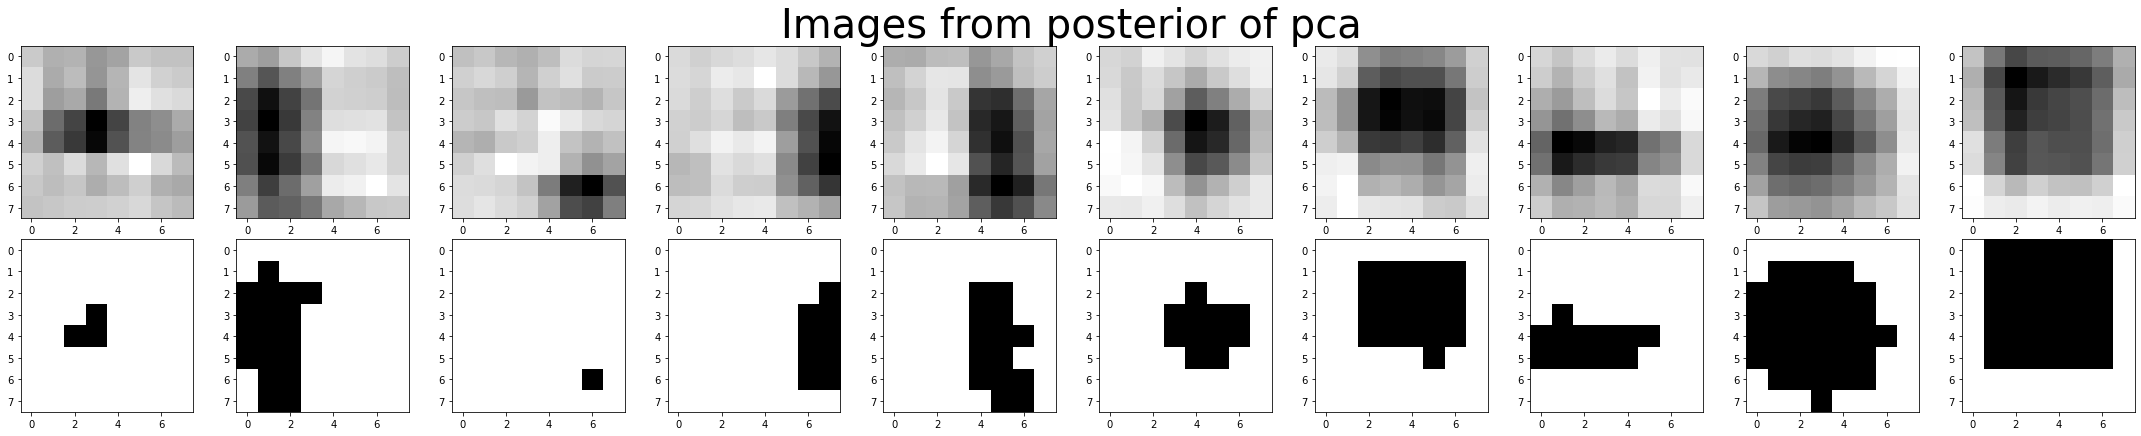

In [37]:
plot_posterior_images('pca', N_TEST=10, show_rounding=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


Area util values:  [ 2 12  2  8 12  6 12  8 16 36]


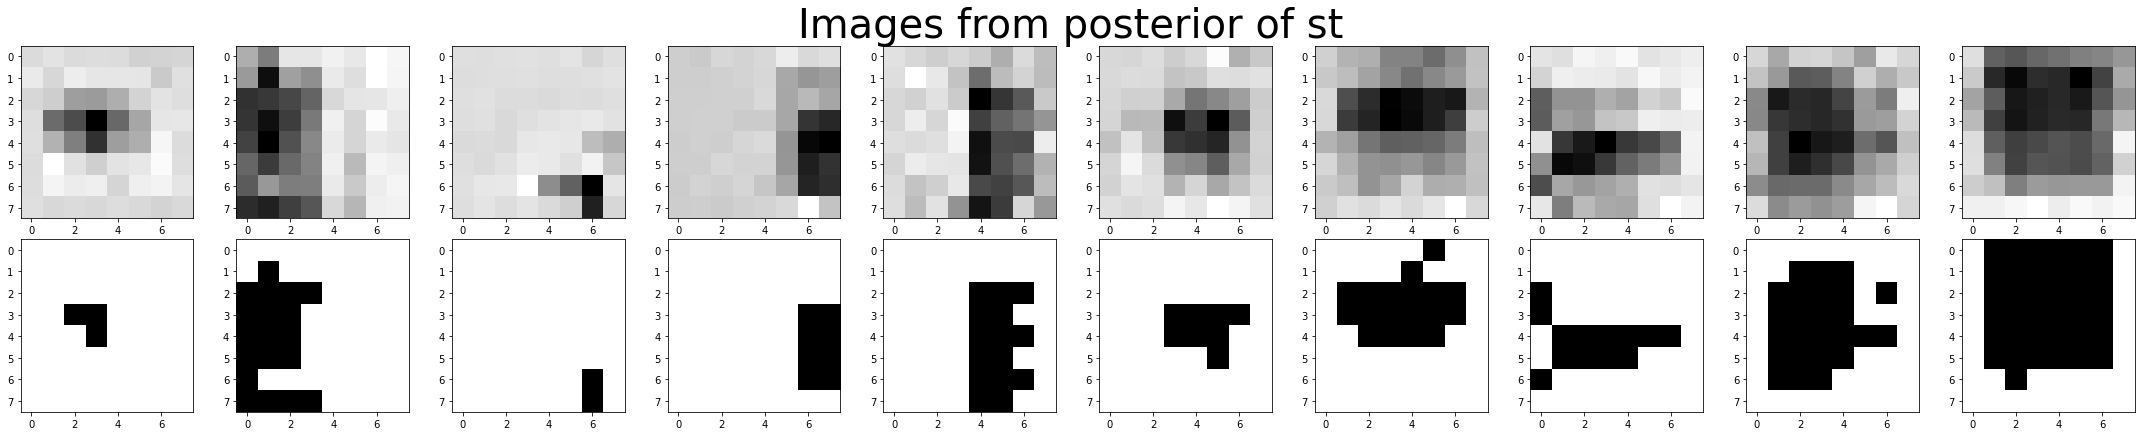

In [38]:
plot_posterior_images('st', N_TEST=10, show_rounding=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Fitting outcome model using random_linear_proj
torch.Size([1000])
Area util values:  [0 1 0 0 0 0 0 1 2 1]


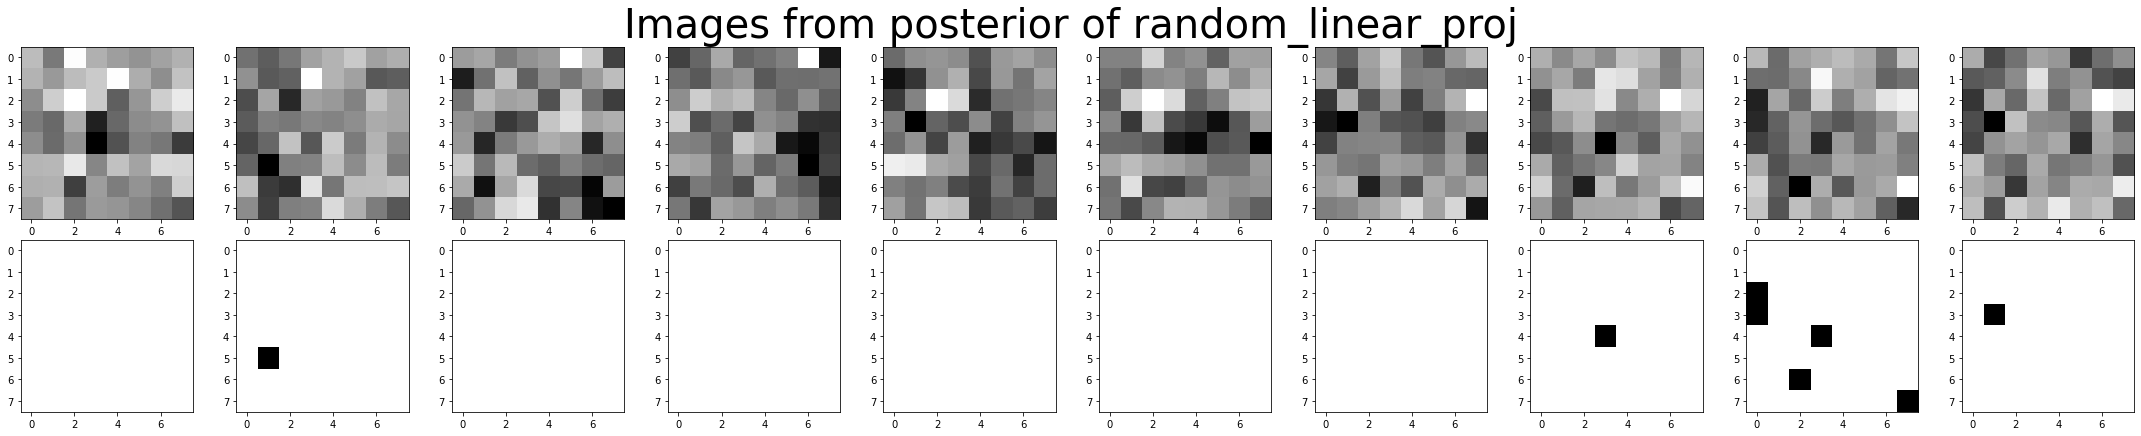

In [40]:
exp.fit_outcome_model("random_linear_proj")
plot_posterior_images('random_linear_proj', N_TEST=10, show_rounding=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [30]:
check_outcome_model_fit(exp.outcome_models_dict["pca"], exp.problem, n_test=1000)

torch.Size([1000])


0.4161078616469422

In [6]:
exp.fit_outcome_model("st")

Fitting outcome model using st


KeyboardInterrupt: 

In [ ]:
check_outcome_model_fit(exp.outcome_models_dict["st"], exp.problem, n_test=1000)

torch.Size([1000])


1.3582117091429613

## Fit utility model and check fit